# Assignment 3: Car prices
_Juan Lopez-Martin_

jl5522@columbia.edu


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

#### Loading data

We will take a subset of 10,000 rows. Note, however, that better accuracy could be obtained with a bigger sample.

In [3]:
df_all = pd.read_csv("vehicles.csv")
n_sample = 10000

# For the initial analysis we made a subset of the dataset
df = df_all.sample(n_sample, random_state = 2020)

Note that I have removed all the exploratory data analysis in the interest of brevity.

#### Preprocessing target

We start by understanding the price, particularly focusing on the lower and upper range.

* Lower range: There are some cars sold at zero or for less than 50 dollars. We suspect that, in many ads, this is a way to 'hide' the price or maybe to make potential buyers click in their ad without seeing the actual price. It could be that these car owners are really giving away their cars, in which case I understand that selling and offering for free are two different phenomena and we should build two models: (1) First, a model that predicts whether the car is sold or given for free; (2) if the car is sold, a model to predict its listing price. Another possibility is that they want to et rid of non-working cars, in which case the two-step classification will make sense as the elements of selling cars that need repairs or are broken may be different from normal cars. As the cars with price < 50 are a minority, we will just remove them. 

* Upper range: There are some extremelly expensive cars (e.g. >200,000) in the dataset. A quick review of these cars (not shown) reveals that they are a mix of errors (e.g. millions of dollars for a car with a listed price of less than 50,000) and not a reflection of actual price (e.g. 111111, 999999) with luxury and antique cars. In particular, an antique car follows different rules than the rest of cars (e.g. for a normal car the newer the better, while for an antique car the older the pricier). Therefore, we will remove cars with a listed price of more than 200,000 from the dataset. If we were interested in luxury and antique cars, we could build a model to distinguish those from the general cars and then one (or two) separate model(s) to estimate their price.

In [4]:
df = df[df.price>50]
df = df[df.price<250000]

## 1. Identify Features

Only based on the descriptions, we can remove the following columns:

* id: unique for each car and not relevant for the prediction task.
* county: it is empty and described as left by mistake.
* url: we have one per row, and therefore, it is not useful as a predictor. 
* region_url: we already have the craiglist region in another variable.
* image_url: same as url.
* vin: vehicle identificaton number is not related to price, as it is just an identifier for the car.
* lat ang long: If we already have the craiglist region the lat and long do not provide much more information. It could, however, be used to geocode the cars for which the craiglist region is missing or identified as "mobile", but we will not do this step as the craiglist region is available for the great majority of cars.

Using the description is tricky, given that it may contain the price of the car. Following a simple approach, we will only use the description to extract some (potentially) relevant features. In particular, we create a feature that represents whether the car contains the word: (1) garage; (2) new; and (3) reliable. These words seem to be related to the condition of the car, and thus could influence its price.


In [5]:
df['description'] = df['description'].str.lower()
df['garage'] = (df.description.str.find("garage")>-1)*1
df['new'] = (df.description.str.find("new")>-1)*1
df['broken'] = (df.description.str.find("broken")>-1)*1
df['worn'] = (df.description.str.find("worn")>-1)*1

The categorical variables we will use are manufacturer, condition, cylinders, fuel, title status, transmission, drive, type, and paint color. We are excluding the model, as there are many car models and that would require the initial model to have too many coefficients.

We have already one-hot encoded the categorical variables in the previous step, using dummy_na=True to include a value for when the value is NA in case that could be informative. Additionally, we will use the SimpleImputer and the StandardScaler on the two continous variables: year and odometer.

In [6]:
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(SimpleImputer(), StandardScaler())

print("year: "+str(np.sum(mutual_info_regression(pipe.fit_transform(df['year'].to_numpy().reshape(-1,1)), df['price']))))
print("odometer: "+str(np.sum(mutual_info_regression(pipe.fit_transform(df['odometer'].to_numpy().reshape(-1,1)), df['price']))))

print("manufacturer: "+str(np.sum(mutual_info_regression(pd.get_dummies(df['manufacturer'], dummy_na=True), df['price'], discrete_features = True))))
print("condition: "+str(np.sum(mutual_info_regression(pd.get_dummies(df['condition'], dummy_na=True), df['price'], discrete_features = True))))
print("cylinders: "+str(np.sum(mutual_info_regression(pd.get_dummies(df['cylinders'], dummy_na=True), df['price'], discrete_features = True))))
print("fuel: "+str(np.sum(mutual_info_regression(pd.get_dummies(df['fuel'], dummy_na=True), df['price'], discrete_features = True))))
print("title_status: "+str(np.sum(mutual_info_regression(pd.get_dummies(df['title_status'], dummy_na=True), df['price'], discrete_features = True))))
print("transmission: "+str(np.sum(mutual_info_regression(pd.get_dummies(df['transmission'], dummy_na=True), df['price'], discrete_features = True))))
print("drive: "+str(np.sum(mutual_info_regression(pd.get_dummies(df['drive'], dummy_na=True), df['price'], discrete_features = True))))
print("type: "+str(np.sum(mutual_info_regression(pd.get_dummies(df['type'], dummy_na=True), df['price'], discrete_features = True))))
print("region: "+str(np.sum(mutual_info_regression(pd.get_dummies(df['region'], dummy_na=True), df['price'], discrete_features = True))))
print("size: "+str(np.sum(mutual_info_regression(pd.get_dummies(df['size'], dummy_na=True), df['price'], discrete_features = True))))
print("paint_color: "+str(np.sum(mutual_info_regression(pd.get_dummies(df['paint_color'], dummy_na=True), df['price'], discrete_features = True))))

print("garage: "+str(np.sum(mutual_info_regression(df['garage'].to_numpy().reshape(-1,1), df['price'], discrete_features = True))))
print("new: "+str(np.sum(mutual_info_regression(df['new'].to_numpy().reshape(-1,1), df['price'], discrete_features = True))))
print("broken: "+str(np.sum(mutual_info_regression(df['broken'].to_numpy().reshape(-1,1), df['price'], discrete_features = True))))
print("worn: "+str(np.sum(mutual_info_regression(df['worn'].to_numpy().reshape(-1,1), df['price'], discrete_features = True))))

year: 0.37344757906094417
odometer: 0.2788979316633018
manufacturer: 0.1326739416498891
condition: 0.1567994389450169
cylinders: 0.09776241467214741
fuel: 0.11931509731237733
title_status: 0.01594272842756128
transmission: 0.03766801500784667
drive: 0.13333890553115202
type: 0.14430922700060633
region: 0.1316931115418738
size: 0.0647525289339469
paint_color: 0.042286605317951476
garage: 0.011837981923026542
new: 0.019417643656625128
broken: 0.00035323409305465514
worn: 0.0002539868948298052


## 2. Preprocessing and Baseline model

For this initial simple model we will only take into account the two continous variables (i.e. year and odometer), the four variables referring to the contents of the description (i.e. garage, new, broken, worn), and five categorical variables: condition, cylinders, fuel, transmission, and drive. Using only five categorical variables allows for a reduced number of coefficients, something very useful for a first model that serves as an initial approach to the data.

The preprocessing only consists in imputing the mean for missing values in the categorical variables, also scaling the features (although this is not necessary, given we will only use unpenalized linear regression). The categorical variables are one-hot encoded. Then we use linear regression, obtaining a cross-validated $R^2$ that is close to 0.35.

In [7]:
# Order categories for easier interpretation of the model
df['condition'] = df['condition'].astype('category').cat.reorder_categories(['excellent', 'fair', 'good', 'like new', 'new', 'salvage'])
df['cylinders'] = df['cylinders'].astype('category').cat.reorder_categories(['3 cylinders', '4 cylinders', '5 cylinders', '6 cylinders','8 cylinders', '10 cylinders', '12 cylinders', 'other'])
df['transmission'] = df['transmission'].astype('category').cat.reorder_categories(['automatic', 'manual', 'other'])
df['fuel'] = df['fuel'].astype('category').cat.reorder_categories(['gas', 'diesel', 'electric', 'hybrid', 'other'])
df['drive'] = df['drive'].astype('category').cat.reorder_categories(['fwd', '4wd', 'rwd'])

X_dummies = pd.get_dummies(df[['condition', 'cylinders', 'fuel', 'transmission', 'drive']], dummy_na=True, drop_first=True)
X_con = df[["year", "odometer"]]
X_cat = df[["garage", "new", "broken", "worn"]]

X = pd.concat([X_con, X_dummies, X_cat], axis = 1)
y = df['price']

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=2020)

pipe = make_pipeline(SimpleImputer(), StandardScaler())
prepros = make_column_transformer((pipe, ['year', 'odometer']), remainder="passthrough")

X_train = prepros.fit_transform(X_train)

In [9]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
scores = cross_val_score(linreg, X_train, y_train, cv=10)
np.mean(scores)

0.3661611237435761

We can visualize the importance of different coefficients as an initial look of the data.

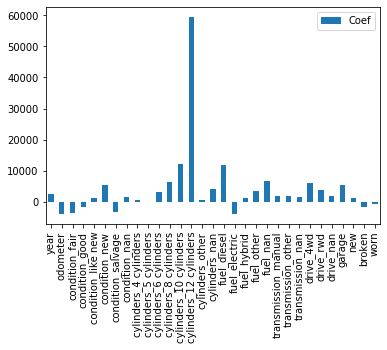

In [10]:
linreg.fit(X_train, y_train)
pd.DataFrame({"Coef":linreg.coef_}, index = X.columns).plot.bar()

In general, the results make sense. The most important factors seems to be that the car has 12 cylinders, whihc is not surprising given this is characteristic of the best sport cars. The rest of the coefficients also make sense, whith the exception of electric cars being cheaper than the baseline gas car. I suspect this is because many of these vehicles are not actually cars, but golf carts and similar vehicles. Regarding the features derived from the description, we see that the words garage or new increase the price as expected, while broken or worn decrease it. 

## 3 & 4. Feature engineering for two models

The new model will be based in four different variations from the previous simple approach:

* Include more categorical variables in the dataset: 'manufacturer', 'fuel', 'title_status', 'paint_color', 'region', 'type', 'transmission', 'size', 'cylinders', 'condition', 'drive'.
* Instead of ignoring missing values in the categorical variables, we will include a new one-hot encoded feature of each of the categorical variables indicating if the row contained a NaN in that variable. This allows us to consider having a NaN as an extra piece of information, which makes sense considering the context (e.g. if someone does not include the condition of the car, it may be that she is hiding it and therefore we would expect a lower price).
* Include the interaction between categorical variables. This step changes for the two models that we will fit, and therefore will be explianed below.
* We will predict the log price instead of the price, as price seems to have a log-normal distribution.

### 3&4.1 Random forest

As in the previous model we will one-hot encode all categorical variables. This, however, makes that the number of possible interactions between the features grows largely. Therefore, we will only consider the interaction between the type of car an the size, transmission, cylinders, condition, and drive.  

In [11]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import FunctionTransformer

# The transformation is implemented in a class (note: this code is a bit wonky)
class Preprocess:
    def __init__(self):
        self.pipe_continous = make_pipeline(SimpleImputer())
        self.poly0 = PolynomialFeatures(2, include_bias=False)
        self.poly1 = PolynomialFeatures(interaction_only=True, include_bias=False)
        self.poly2 = PolynomialFeatures(interaction_only=True, include_bias=False)
        self.poly3 = PolynomialFeatures(interaction_only=True, include_bias=False)
        self.poly4 = PolynomialFeatures(interaction_only=True, include_bias=False)
        self.poly5 = PolynomialFeatures(interaction_only=True, include_bias=False)
    def fit(self, df):
        df1 = pd.get_dummies(df[['type', 'size']], dummy_na=True, drop_first=True)
        df2 = pd.get_dummies(df[['type', 'transmission']], dummy_na=True, drop_first=True)
        df3 = pd.get_dummies(df[['type', 'cylinders']], dummy_na=True, drop_first=True)
        df4 = pd.get_dummies(df[['type', 'condition']], dummy_na=True, drop_first=True)
        df5 = pd.get_dummies(df[['type', 'drive']], dummy_na=True, drop_first=True)
    
        self.pipe_continous.fit(df[["year", "odometer"]])
        self.poly1.fit(df1)
        self.poly2.fit(df2)
        self.poly3.fit(df3)
        self.poly4.fit(df4)
        self.poly5.fit(df5)
    def transform(self, df):
        df1 = pd.get_dummies(df[['type', 'size']], dummy_na=True, drop_first=True)
        df2 = pd.get_dummies(df[['type', 'transmission']], dummy_na=True, drop_first=True)
        df3 = pd.get_dummies(df[['type', 'cylinders']], dummy_na=True, drop_first=True)
        df4 = pd.get_dummies(df[['type', 'condition']], dummy_na=True, drop_first=True)
        df5 = pd.get_dummies(df[['type', 'drive']], dummy_na=True, drop_first=True)
        
        self.names1 = self.poly1.get_feature_names(df1.columns)
        self.names2 = self.poly2.get_feature_names(df2.columns)
        self.names3 = self.poly3.get_feature_names(df3.columns)
        self.names4 = self.poly4.get_feature_names(df4.columns)
        self.names5 = self.poly5.get_feature_names(df5.columns)
        
        self.poly0.fit(self.pipe_continous.transform(df[["year", "odometer"]]))
        X_con = self.poly0.transform(self.pipe_continous.transform(df[["year", "odometer"]]))
        X_dummies = pd.get_dummies(df[['manufacturer', 'fuel', 'title_status', 'paint_color', 'region', 'type', 'transmission', 'size', 'cylinders', 'condition', 'drive']], dummy_na=True, drop_first=True)
        X_cat = df[["garage", "new", "broken", "worn"]].to_numpy()
        
        X_dummy1 = self.poly1.transform(df1)[:, [" " in name for name in self.names1]]
        X_dummy2 = self.poly2.transform(df2)[:, [" " in name for name in self.names2]]
        X_dummy3 = self.poly3.transform(df3)[:, [" " in name for name in self.names3]]
        X_dummy4 = self.poly4.transform(df4)[:, [" " in name for name in self.names4]]
        X_dummy5 = self.poly5.transform(df5)[:, [" " in name for name in self.names5]]
        
        X = np.concatenate((X_con, X_dummies, X_dummy1, X_dummy2, X_dummy3, X_dummy4, X_dummy5, X_cat), axis = 1)
        
        return(X)
        
    def get_names(self, df):
        
        n0 = self.poly0.get_feature_names(["year", "odometer"])
        n1 = pd.get_dummies(df[['manufacturer', 'fuel', 'title_status', 'paint_color', 'region', 'type', 'transmission', 'size', 'cylinders', 'condition', 'drive']], dummy_na=True, drop_first=True).columns
        n2 = np.array(self.names1)[np.array([" " in name for name in self.names1])]
        n3 = np.array(self.names2)[np.array([" " in name for name in self.names2])]
        n4 = np.array(self.names3)[np.array([" " in name for name in self.names3])]
        n5 = np.array(self.names4)[np.array([" " in name for name in self.names4])]
        n6 = np.array(self.names5)[np.array([" " in name for name in self.names5])]
        n7 = np.array(["garage", "new", "broken", "worn"])
        
        return(np.concatenate([n0,np.array(n1),n2,n3,n4,n5,n6,n7]))

In [12]:
df = df.replace(' ', '_', regex=True)

prep = Preprocess()
prep.fit(df)
X = prep.transform(df)
coefnames = prep.get_names(df)
y = FunctionTransformer(np.log, np.exp, validate = True).fit_transform(df['price'].to_numpy().reshape(-1, 1)).ravel()

X_rf_train, X_rf_test, y_rf_train, y_rf_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=2020)

In [13]:
X_rf_train.shape

(6050, 1253)

The final dataset consists of 1253 features. We will use random forests to build an initial classifier with all these features. We will not perform any parameter tuning as (a) the default number of estimators of 100 is reasonable, as more will lead to a extremelly slow process with a small gain in performance, and (b) the max_depth and min_samples_split can be modified mostly to avoid extreme memory consumption and processing time, but right now with a subsample of 10,000 the performance with the default is good.

In [14]:
from sklearn.ensemble import RandomForestRegressor

rfo = RandomForestRegressor(n_estimators = 100)
rfo.fit(X_rf_train, y_rf_train)
rfo.score(X_rf_test, y_rf_test)

0.5779915849510742

We obtain an $R^2$ close to 0.6, which is much better than the linear model described above.

### 3&4.2 Gradient boosting with catboost

In [15]:
newdf = df[['manufacturer', 'fuel', 'title_status', 'paint_color', 'region', 'transmission', 'type', 'size', 'cylinders', 'condition', 'drive', 'garage', 'new', 'broken', 'worn']]
newdf = newdf.replace(np.nan, 'NAN', regex=True)

newdf['type size'] = newdf['type'].values + " " + newdf['size'].values
newdf['type transmission'] = newdf['type'].values + " " + newdf['transmission'].values
newdf['type cylinders'] = newdf['type'].values + " " + newdf['cylinders'].values
newdf['type condition'] = newdf['type'].values + " " + newdf['condition'].values
newdf['type drive'] = newdf['type'].values + " " + newdf['drive'].values
newdf['type manufacturer'] = newdf['type'].values + " " + newdf['manufacturer'].values
newdf['type fuel'] = newdf['type'].values + " " + newdf['fuel'].values
newdf['type region'] = newdf['type'].values + " " + newdf['region'].values

newdf['size transmission'] = newdf['size'].values + " " + newdf['transmission'].values
newdf['size cylinders'] = newdf['size'].values + " " + newdf['cylinders'].values
newdf['size condition'] = newdf['size'].values + " " + newdf['condition'].values
newdf['size drive'] = newdf['size'].values + " " + newdf['drive'].values
newdf['size manufacturer'] = newdf['size'].values + " " + newdf['manufacturer'].values
newdf['size fuel'] = newdf['size'].values + " " + newdf['fuel'].values
newdf['size region'] = newdf['size'].values + " " + newdf['region'].values

newdf['cylinders condition'] = newdf['cylinders'].values + " " + newdf['condition'].values
newdf['cylinders drive'] = newdf['cylinders'].values + " " + newdf['drive'].values
newdf['cylinders manufacturer'] = newdf['condition'].values + " " + newdf['manufacturer'].values
newdf['cylinders fuel'] = newdf['condition'].values + " " + newdf['fuel'].values
newdf['cylinders region'] = newdf['cylinders'].values + " " + newdf['region'].values

newdf['condition drive'] = newdf['condition'].values + " " + newdf['drive'].values
newdf['condition manufacturer'] = newdf['condition'].values + " " + newdf['manufacturer'].values
newdf['condition fuel'] = newdf['condition'].values + " " + newdf['fuel'].values
newdf['condition region'] = newdf['condition'].values + " " + newdf['region'].values

newdf['drive manufacturer'] = newdf['drive'].values + " " + newdf['manufacturer'].values
newdf['drive fuel'] = newdf['drive'].values + " " + newdf['fuel'].values
newdf['drive region'] = newdf['drive'].values + " " + newdf['region'].values

newdf['manufacturer fuel'] = newdf['manufacturer'].values + " " + newdf['fuel'].values
newdf['manufacturer region'] = newdf['manufacturer'].values + " " + newdf['region'].values

newdf['fuel region'] = newdf['fuel'].values + " " + newdf['region'].values

newdf["year"] = df["year"]
newdf["year2"] = df["year"]*df["year"]
newdf["odometer"] = df["odometer"]
newdf["odometer2"] = df["odometer"]*df["odometer"]
newdf["year odometer"] = df["year"]*df["odometer"]

y = FunctionTransformer(np.log, np.exp, validate = True).fit_transform(df['price'].to_numpy().reshape(-1, 1)).ravel()

In [16]:
X_gb_train, X_gb_test, y_gb_train, y_gb_test = train_test_split(newdf, y, test_size=0.33, shuffle=True, random_state=2020)
X_gb_train.shape

(6050, 50)

Without any parameter tuning, we get an $R^2$ that is slightly better than the one obtained by the random forest.

In [17]:
from catboost import CatBoostRegressor

model_default = CatBoostRegressor(loss_function='RMSE', custom_metric='RMSE', cat_features=list(range(0,45)), metric_period = 500)

model_default.fit(X_gb_train, y_gb_train, cat_features=list(range(0,45)), metric_period = 500)
model_default.score(X_gb_test, y_gb_test)

Learning rate set to 0.053772
0:	learn: 0.9333529	total: 99.3ms	remaining: 1m 39s
500:	learn: 0.5118250	total: 24.3s	remaining: 24.2s
999:	learn: 0.4589303	total: 48.3s	remaining: 0us


0.6049706250736715

In [18]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

model_init = CatBoostRegressor(loss_function='RMSE', custom_metric='RMSE', cat_features=list(range(0,45)), 
                              metric_period = 500)
grid = dict(learning_rate = [0.025, 0.05, 0.075, 0.1, 0.125],
            max_depth= [8, 10],
            l2_leaf_reg = [2, 10, 30],
           iterations = [500, 1000])

model_init.randomized_search(grid,
                             X=X_gb_train,
                             y=y_gb_train,
                             plot=True)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	loss: 0.5813050	best: 0.5813050 (0)	total: 43.9s	remaining: 6m 35s
1:	loss: 0.5860049	best: 0.5813050 (0)	total: 1m 27s	remaining: 5m 48s
2:	loss: 0.5744109	best: 0.5744109 (2)	total: 2m 54s	remaining: 6m 47s
3:	loss: 0.5792592	best: 0.5744109 (2)	total: 4m 28s	remaining: 6m 42s
4:	loss: 0.5892581	best: 0.5744109 (2)	total: 6m	remaining: 6m
5:	loss: 0.5947862	best: 0.5744109 (2)	total: 7m 30s	remaining: 5m
6:	loss: 0.5969935	best: 0.5744109 (2)	total: 8m 24s	remaining: 3m 36s
7:	loss: 0.5952309	best: 0.5744109 (2)	total: 9m 26s	remaining: 2m 21s
8:	loss: 0.5795600	best: 0.5744109 (2)	total: 11m 26s	remaining: 1m 16s
9:	loss: 0.5890548	best: 0.5744109 (2)	total: 13m 31s	remaining: 0us
Estimating final quality...


{'params': {'depth': 8,
  'l2_leaf_reg': 2,
  'iterations': 1000,
  'learning_rate': 0.05},
 'cv_results': defaultdict(list,
             {'iterations': [0, 500, 999],
              'test-RMSE-mean': [8.76514196308869,
               0.5998828133563552,
               0.5985309922461312],
              'test-RMSE-std': [0.04144327188106242,
               0.007717617102222981,
               0.00789435427458243],
              'train-RMSE-mean': [8.766971315749279,
               0.4355233891346965,
               0.3216840731826702],
              'train-RMSE-std': [0.017565189939516928,
               0.012637684679880884,
               0.005887672608879567]})}

Although we see a very small increase after parameter tuning, the difference seems to be a bit disappointing considering the time it took to do grid-search (although this obviously depends on the application, and a small increase could be very relevant in certain contexts).

In [19]:
model_init.score(X_gb_test, y_gb_test)

0.6098618228769951

## 5 Feature Selections

### 5.1 Random Forest

First, we will take a look at the first 20 features with highest feature_importances_.

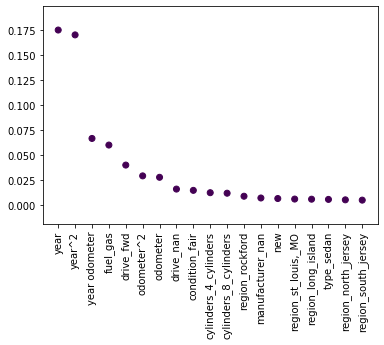

In [20]:
coefs = pd.Series(rfo.feature_importances_, index = coefnames)
greater_cofs = coefs.sort_values(ascending = False)[0:19]
greater_cofs = coefs.loc[greater_cofs.index]
plt.scatter(greater_cofs.index, greater_cofs, c = np.sign(greater_cofs))
plt.xticks(rotation=90)
plt.show()

However, having more than 1,000 features was definetely too much for this case. We will try to take a look at how the model will perform with less features using RFECV. In general, we see there is not a big increased benefit going beyond 400 feautres, and even with only 200 feaures gets a very reasonable performance. 

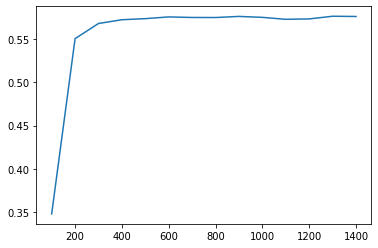

In [21]:
from sklearn.feature_selection import RFECV

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=2020)

rfo = RandomForestRegressor(n_estimators = 100)
rfecv = RFECV(estimator=rfo, step=100, cv=3)
rfecv.fit(X_train, y_train)
plt.plot(np.array(range(1, len(rfecv.grid_scores_) + 1))*100, rfecv.grid_scores_)

SelectFromModel selects 216 features based on a 0.5\*Mean threshold, which sounded a reasonable approach to select features while not reducing the number of features too much in order to avoid losing a lot of performance. 

In [22]:
from sklearn.feature_selection import SelectFromModel

rfo.fit(X_rf_train, y_rf_train)

model_k = SelectFromModel(estimator=rfo, prefit=True, threshold = "0.5*mean")
X_rf_train_new = model_k.transform(X_rf_train)
X_rf_train_new.shape

(6050, 217)

The performance is very close to the original model, having reduced the number of features from 1253 to 219.

In [23]:
rfo_sel = RandomForestRegressor(n_estimators = 1000)
rfo_sel.fit(X_rf_train_new, y_rf_train)
rfo_sel.score(model_k.transform(X_rf_test), y_rf_test)

0.5779898918499893

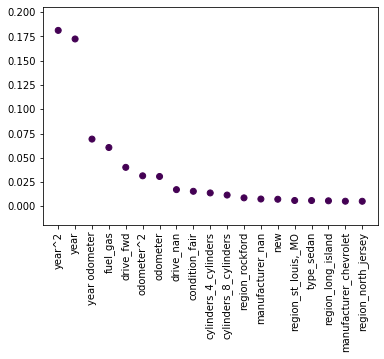

In [24]:
coefs = pd.Series(rfo_sel.feature_importances_, index = coefnames[model_k.get_support()])
greater_cofs = coefs.sort_values(ascending = False)[0:19]
greater_cofs = coefs.loc[greater_cofs.index]
plt.scatter(greater_cofs.index, greater_cofs, c = np.sign(greater_cofs))
plt.xticks(rotation=90)
plt.show()

### 5.2 Gradient boosting with catboost

First, we should take a look at the feature importances. The year of the vehicle seems like the most important factor, followed by the odometer. This makes sense, as these two characteristics very clearly relate with the price.

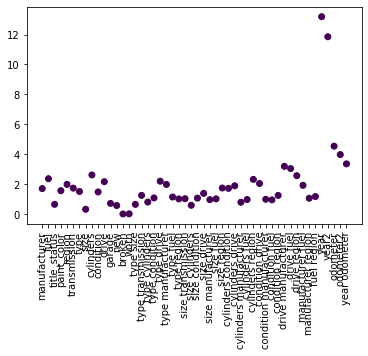

In [25]:
coefs = pd.Series(model_init.feature_importances_, index = X_gb_train.columns)
plt.scatter(coefs.index, coefs, c = np.sign(coefs))
plt.xticks(rotation=90)
plt.show()

Using SelectFromModel with threshold = "mean" selects only 12 features. 

In [26]:
model_k = SelectFromModel(estimator=model_init, prefit=True, threshold = "mean")
X_gb_train_new = np.array(X_gb_train)[:, model_k.get_support()]
X_gb_train_new.shape

(6050, 14)

The features that are selected seem to make sense.

In [27]:
X_gb_train.columns[model_k.get_support()]

Index(['fuel', 'cylinders', 'drive', 'type drive', 'cylinders region',
       'condition drive', 'drive manufacturer', 'drive fuel', 'drive region',
       'year', 'year2', 'odometer', 'odometer2', 'year odometer'],
      dtype='object')

The performance of this model is obviously a bit lower compared to the one that incldued all features, but the decrease is quite small given how many features were removed.

In [28]:
params = model_init.get_params()
# delete the cat_features as the input dataset will be smaller, so we will have to define this again
del params['cat_features']

catb_simple = CatBoostRegressor(**params)
catb_simple.fit(X_gb_train_new, y_gb_train, cat_features=list(range(0,9)), metric_period = 500)
catb_simple.score(np.array(X_gb_test)[:, model_k.get_support()], y_gb_test)

0:	learn: 0.9336402	total: 37.6ms	remaining: 37.6s
500:	learn: 0.4418735	total: 21.8s	remaining: 21.7s
999:	learn: 0.3523009	total: 43.7s	remaining: 0us


0.6007905630340078

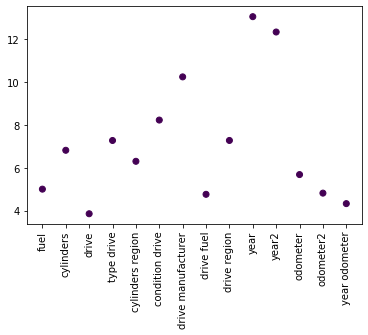

In [29]:
coefs = pd.Series(catb_simple.feature_importances_, index = X_gb_train.columns[model_k.get_support()])
plt.scatter(coefs.index, coefs, c = np.sign(coefs))
plt.xticks(rotation=90)
plt.show()

Interestingly, removing all the interaction parameters from this latter model does not reduce the performance as much as I would have expected.

In [30]:
X_gb_train_new2 = np.array(X_gb_train)[:, model_k.get_support()][:, [0,1,2,3,9,10,10]]
catb_simple = CatBoostRegressor(**params)
catb_simple.fit(X_gb_train_new2, y_gb_train, cat_features=list(range(0,4)), metric_period = 500)
catb_simple.score(np.array(X_gb_test)[:, model_k.get_support()][:, [0,1,2,3,9,10,10]], y_gb_test)

0:	learn: 0.9332067	total: 30.1ms	remaining: 30s
500:	learn: 0.5815081	total: 9.99s	remaining: 9.95s
999:	learn: 0.5406949	total: 21.1s	remaining: 0us


0.5130638832172602

## 6. An explainable model

For the explainable model we will avoid the features we built for previous models. A model can still be explainable with these features, but we wanted to avoid them in order for it to be extremelly intuitive. However, we should highlight that a more accurate model with a similar explainability could be built using these constructed features.

In [31]:
X_con = df[["year", "odometer"]]
X_dummies = pd.get_dummies(df[['manufacturer', 'fuel', 'title_status', 'paint_color', 'region', 'type', 'transmission', 'size', 'cylinders', 'condition', 'drive']], dummy_na=True, drop_first=True)
X_cat = df[["garage", "new", "broken", "worn"]]

X = pd.concat([X_con, X_dummies, X_cat], axis = 1)
y = FunctionTransformer(np.log, np.exp, validate = True).fit_transform(df['price'].to_numpy().reshape(-1, 1)).ravel()
#y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=2020)

We do a (manual) grid-search for the maximum depth of the tree and the number of features to use. The results show that a tree with depth 4 with 3 or 4 features could be a simple model that still obtained acceptable accuracy.

In [32]:
from sklearn.tree import DecisionTreeRegressor

max_depths = range(1,7)
max_features = range(1,21)

from sklearn.model_selection import cross_val_score

mat = np.empty([len(max_depths), len(max_features)])

for i, max_depth in enumerate(max_depths):
    tree_pipe = make_pipeline(SimpleImputer(), DecisionTreeRegressor(max_depth = max_depth))
    tree_pipe.fit(X_train, y_train)
    for j, max_feature in enumerate(max_features):
        model_k = SelectFromModel(estimator=tree_pipe[1], prefit=True, max_features = max_feature)
        X_train_new = X_train.loc[:,model_k.get_support()]
        mat[i,j] = np.mean(cross_val_score(tree_pipe, X_train_new, y_train, cv = 10))

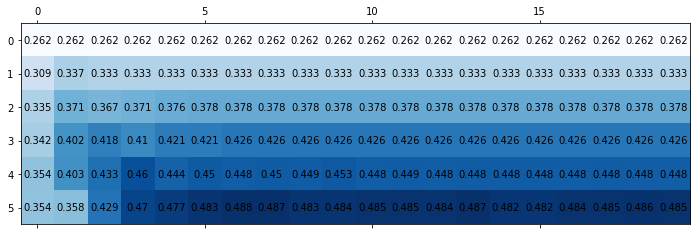

In [33]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.matshow(mat, cmap=plt.cm.Blues)
for i in range(0, len(max_depths)):
    for j in range(0, len(max_features)):
        c = np.round(mat[i,j],3)
        ax.text(j, i, str(c), va='center', ha='center')

In [34]:
tree_pipe = make_pipeline(SimpleImputer(), DecisionTreeRegressor(max_depth = 5))
tree_pipe.fit(X_train, y_train)
model_k = SelectFromModel(estimator=tree_pipe[1], prefit=True, max_features = 4)

In [35]:
relevant_features = model_k.get_support()
X_train_new = X_train.loc[:,relevant_features]
tree_pipe.fit(X_train_new, y_train)
tree_pipe.score(X_test.loc[:,relevant_features], y_test)

0.4570294170821637

It was surprising to me that with only 4 of the original (non-processed) features we could build a tree of depth 5 that still produced an $R^2$ close to 0.46. This model is very interpretable in the sense that it is quite small and with few non-processed features. More accurate models can be obtained, but they will sacrifice explainability.

In [36]:
X_train.loc[:,relevant_features].columns

Index(['year', 'odometer', 'fuel_gas', 'drive_fwd'], dtype='object')

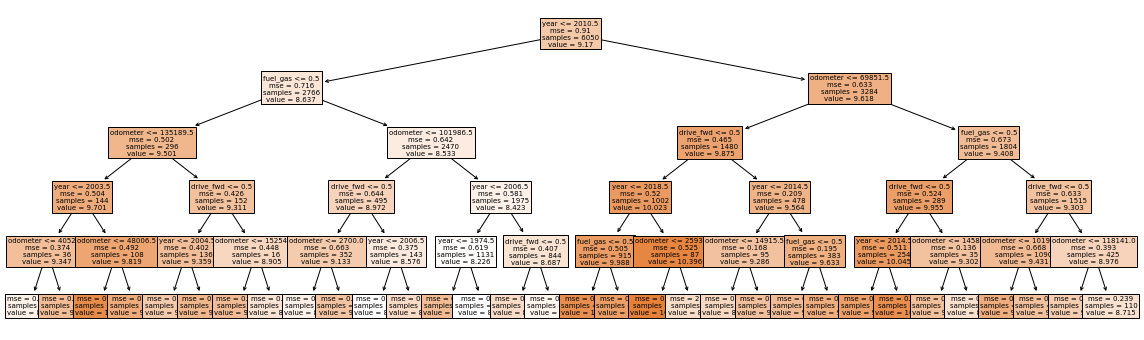

In [37]:
from sklearn.tree import plot_tree

fig, ax = plt.subplots(figsize=(20, 6))

plot_tree(tree_pipe[1], filled=True, fontsize = 7, feature_names = X_train.loc[:,relevant_features].columns, ax = ax)

plt.show()